In [15]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import moyra as mf
import moyra.elements as ele
import moyra.forces as ef
import FwtModels.RectWing as rw
import FwtModels.TwoDoF as TwoDoF

from matplotlib.lines import Line2D

me.mechanics_printing()

In [16]:
half = sym.Rational(1,2)
fwt_panels = 10
p = TwoDoF.base_params(panels = fwt_panels)

In [17]:
#Define refernce frames
wing_root_frame = mf.HomogenousTransform().Translate(0,0,p.q[0]).R_x(-p.q[1])

#Define Mass Matrices
M_fwt = ele.MassMatrix(p.m,I_xx = p.I_xx)

# Define Elements
M_innerWing = ele.RigidElement.point_mass(wing_root_frame,p.m_w,True)
fwt_ele = ele.RigidElement(wing_root_frame.Translate(0,p.l_com,0),M_fwt,True)
spring_ele = ele.Spring(p.q[0],p.k_w)

# Define Aero Forces
wing_AeroForces = ef.AeroForce.PerUnitSpan(p,wing_root_frame.Translate(0,p.y_i,0),p.a_0,
                               alphadot = 0,
                               M_thetadot = 0,
                               e = 0,
                               w_g = 0,
                               rootAlpha = p.alpha_1,
                               alpha_zero = 0,
                               stall_angle = 0,
                               c = p.c,
                               V = p.V,
                               c_d_max = 0,
                               linear = True)

# split Main Wing into segments
forces = []
for i in range(fwt_panels):
    seg_width = p.s/fwt_panels
    yi = seg_width/2 + i*seg_width
    forces.append(wing_AeroForces.subs({p.y_i:yi,p.a_0:p.a[i]})*seg_width)
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
wing_AeroForces = ef.ExternalForce(Q)

In [24]:
# create instance of the model
sm = mf.SymbolicModel.FromElementsAndForces(p,[M_innerWing,fwt_ele,spring_ele],ExtForces = wing_AeroForces)

In [25]:
sm.to_file(p,'2Dof_Model.py')

In [26]:
(sm,p) = mf.SymbolicModel.from_file('2Dof_Model.py')

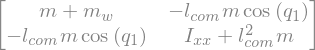

In [27]:
sm.M

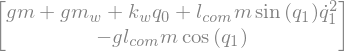

In [30]:
sm.f

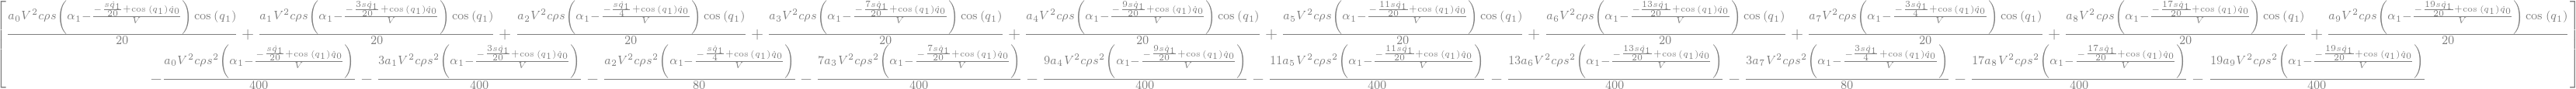

In [31]:
sm.ExtForces.Q()

In [ ]:
sm.Ext